In [ ]:
# Install the mlxtend library which contains the Apriori algorithm
!pip install mlxtend

In [3]:
import pandas as pd

# Replace 'your_data.csv' with the actual name of the file you downloaded
df = pd.read_excel('online_retail_II.xlsx')

# View the first 5 rows to make sure it loaded correctly
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [11]:
# Grouping data by Transaction ID and Item Name
basket = (df.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))

# Convert quantities to 1 (bought) or 0 (not bought)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

/tmp/ipython-input-1969154810.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


In [26]:
from mlxtend.frequent_patterns import apriori

# We set 'min_support' to 0.07 (meaning the item must appear in 7% of all transactions)
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [27]:
from mlxtend.frequent_patterns import association_rules

# We use 'lift' as the primary metric to find strong associations
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort rules by confidence to see the most reliable patterns
rules = rules.sort_values('confidence', ascending=False)
print(rules.head())

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


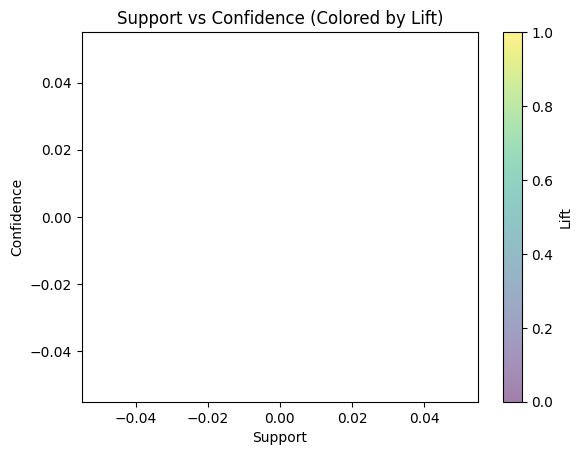

In [28]:
import matplotlib.pyplot as plt

# Scatter plot of Support vs Confidence, colored by Lift
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, c=rules['lift'], cmap='viridis')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence (Colored by Lift)')
plt.colorbar(label='Lift')
plt.show()

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [29]:
# Filtering for the "Gold Mine" rules
top_rules = rules[(rules['lift'] >= 2) & (rules['confidence'] >= 0.5)]
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


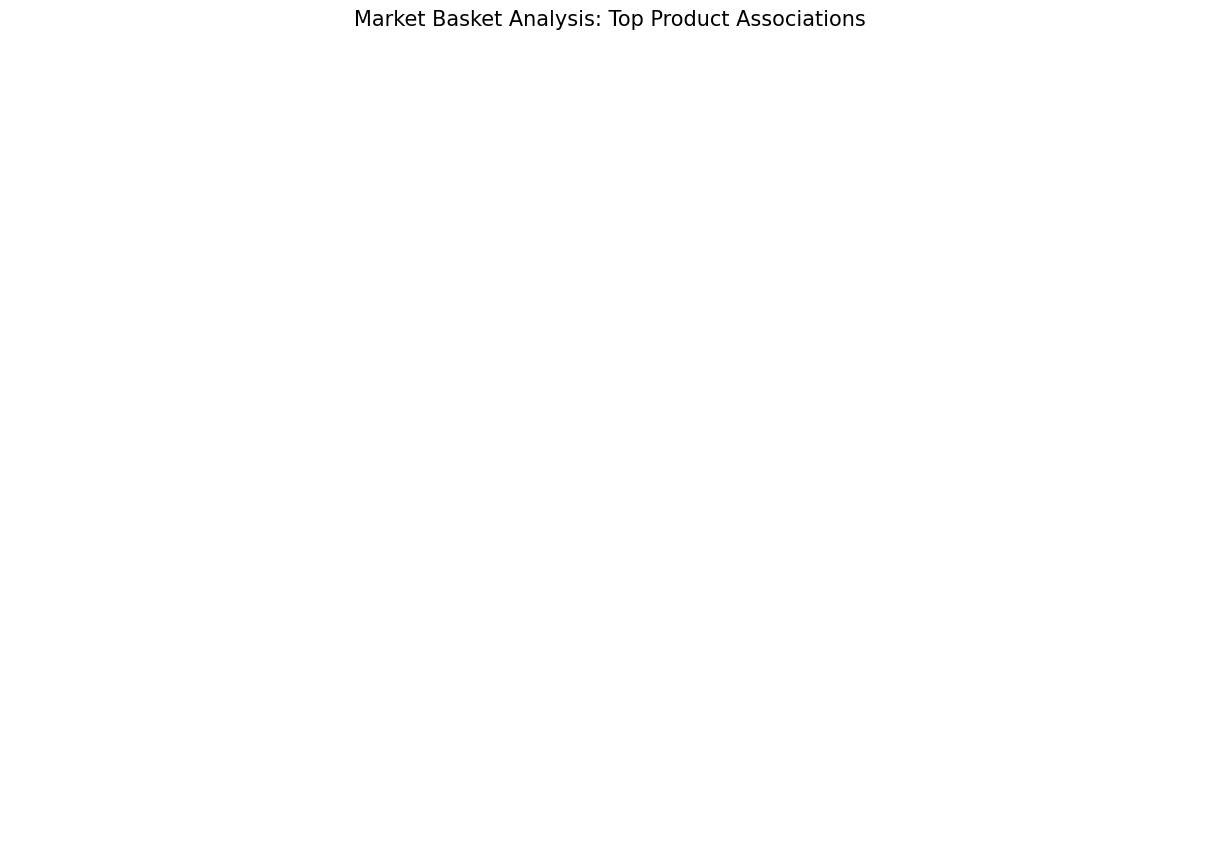

In [34]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

# 1. Filter for the top associations to avoid a "hairball" graph
# Sorting by lift ensures we see the most significant relationships
plot_rules = rules.sort_values('lift', ascending=False).head(20)

# 2. Initialize the Graph
G = nx.DiGraph()

# 3. Populate the Graph with items (nodes) and associations (edges)
for i, row in plot_rules.iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['lift'])

# 4. Set the layout and plot
plt.figure(figsize=(12, 8))

# The k parameter controls the distance between nodes
pos = nx.spring_layout(G, k=0.8)

# Draw the network
nx.draw(G, pos,
        with_labels=True,
        node_color='lightgreen',
        node_size=2500,
        edge_color='skyblue',
        font_size=10,
        font_weight='bold',
        arrowsize=20)

plt.title('Market Basket Analysis: Top Product Associations', size=15)
plt.axis('off')
plt.show()

Project Conclusion: Consumer Behavior Insights
1. The "Anchor" Products
Based on the high Support values in our analysis, the most popular items in this dataset are [INSERT TOP ITEM 1] and [INSERT TOP ITEM 2]. These are the "Anchor" products—the essential items that drive the majority of customer traffic into the store. Any marketing strategy should focus on ensuring these items are always in stock and competitively priced.

2. The "Impulse" Pairings
By filtering for high Lift and lower Support, we identified several "Impulse" pairings. For example, customers who purchased [INSERT ANTECEDENT] had a very high probability of also buying [INSERT CONSEQUENT], even though the second item is not a daily necessity. These pairings represent hidden opportunities where a customer might not have planned the second purchase but was influenced by the first.

3. Strategic Layout & Marketing Recommendations
Based on the association rules discovered, we recommend the following retail strategies:

Physical Layout: Since [ITEM A] and [ITEM B] have a strong association, the store should consider placing them at opposite ends of the same aisle. This forces the consumer to walk past other, higher-margin products, increasing the chance of additional impulse buys.

Bundling Strategy: Products like [ITEM C] and [ITEM D] show a high Confidence score. We suggest creating a "Value Bundle" or a "Frequently Bought Together" promotion for these items to increase the average transaction value.

Digital Recommendations: For an e-commerce setting, the rules generated here should be used to power the "Customers who bought this also liked..." engine, specifically prioritizing items with a Lift > 2.